In [1]:
import numpy as np
import re
import pandas as pd
import glob
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS as tabcols

from sklearn.linear_model  import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,accuracy_score,recall_score,precision_score,f1_score
import lightgbm as lgb

In [2]:
from  movies_params  import feature_cols,target_col
rnd = 499
np.random.seed(rnd)


### Загрузка данных

In [3]:
df = pd.read_csv('datasets/movies.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  290 non-null    int64  
 1   movie       290 non-null    object 
 2   B2_freq     266 non-null    float64
 3   A2_freq     266 non-null    float64
 4   A1_freq     266 non-null    float64
 5   B1_freq     266 non-null    float64
 6   C1_freq     266 non-null    float64
 7   B2_rate     266 non-null    float64
 8   A2_rate     266 non-null    float64
 9   A1_rate     266 non-null    float64
 10  B1_rate     266 non-null    float64
 11  C1_rate     266 non-null    float64
 12  qty         266 non-null    float64
 13  ne          266 non-null    float64
 14  avg_length  266 non-null    float64
 15  level       241 non-null    object 
dtypes: float64(13), int64(1), object(2)
memory usage: 36.4+ KB


Собранный датасет  экспортируются как full outer join, что бы можно было оценить его качество и количество промахов.   
Но здесь незаполненнные поля исправить неоткуда, поэтому я просто удаляю ошибки подготовки   
Также удаляю колонки, не нужные в моделировании (в это версии только названия фильмов)

In [4]:
df = df[~df.isna().any(axis=1)]
drop_cols = [c for c in df.columns if c not in feature_cols+[target_col]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 0 to 265
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  217 non-null    int64  
 1   movie       217 non-null    object 
 2   B2_freq     217 non-null    float64
 3   A2_freq     217 non-null    float64
 4   A1_freq     217 non-null    float64
 5   B1_freq     217 non-null    float64
 6   C1_freq     217 non-null    float64
 7   B2_rate     217 non-null    float64
 8   A2_rate     217 non-null    float64
 9   A1_rate     217 non-null    float64
 10  B1_rate     217 non-null    float64
 11  C1_rate     217 non-null    float64
 12  qty         217 non-null    float64
 13  ne          217 non-null    float64
 14  avg_length  217 non-null    float64
 15  level       217 non-null    object 
dtypes: float64(13), int64(1), object(2)
memory usage: 28.8+ KB


In [5]:
dx = df.drop(drop_cols,axis=1).copy()

### Предварительный анализ данных

Имена признаков записываются на этапе подготовки и сохраняются в передаточном файле, прочитаем прочитаем их оттуда  проведем разбиение на тренировочный и тестовый наборы.

In [6]:
X = feature_cols
y = target_col
tr_X,te_X,tr_y,te_y= train_test_split(dx[X],dx[y],test_size = 0.2,shuffle=True)

Корреляций нет 

In [7]:
dx[X].corr()

,A1_freq,A2_freq,B1_freq,B2_freq,C1_freq,A1_rate,A2_rate,B1_rate,B2_rate,C1_rate,qty,ne,avg_length
A1_freq,1.000000,-0.087461,-0.182791,-0.446949,-0.214703,0.565131,0.236604,0.108092,-0.244977,-0.336829,0.196918,-0.291314,-0.497754
A2_freq,-0.087461,1.000000,0.054099,0.112940,0.002246,-0.109032,0.451949,0.068684,0.119093,0.041527,-0.090086,-0.088883,0.356207
B1_freq,-0.182791,0.054099,1.000000,0.512593,0.441599,-0.059411,0.097884,0.662017,0.492660,0.431306,-0.287107,-0.251325,0.375182
B2_freq,-0.446949,0.112940,0.512593,1.000000,0.304681,-0.165669,0.141117,0.341146,0.793290,0.402090,-0.407516,-0.129733,0.547415
C1_freq,-0.214703,0.002246,0.441599,0.304681,1.000000,-0.033921,0.050469,0.377693,0.366575,0.650369,-0.247245,-0.155699,0.219043
A1_rate,0.565131,-0.109032,-0.059411,-0.165669,-0.033921,1.000000,0.491045,0.168329,-0.143928,-0.386166,-0.476154,-0.192351,-0.243745
A2_rate,0.236604,0.451949,0.097884,0.141117,0.050469,0.491045,1.000000,0.266298,0.207458,-0.106664,-0.396677,-0.330760,0.066501
B1_rate,0.108092,0.068684,0.662017,0.341146,0.377693,0.168329,0.266298,1.000000,0.392710,0.307941,-0.198587,-0.311758,0.063990
B2_rate,-0.244977,0.119093,0.492660,0.793290,0.366575,-0.143928,0.207458,0.392710,1.000000,0.477766,-0.245270,-0.203506,0.391485
C1_rate,-0.336829,0.041527,0.431306,0.402090,0.650369,-0.386166,-0.106664,0.307941,0.477766,1.000000,-0.006391,-0.148421,0.221285


Посмотрим зависимость средних по категориям.  
Есть ожидаемый прогресс с ростом категории, но возможно он очень слабый для хороших предсказаний  

In [8]:
df.groupby('level')[X].agg(pd.Series.mean)

,A1_freq,A2_freq,B1_freq,B2_freq,C1_freq,A1_rate,A2_rate,B1_rate,B2_rate,C1_rate,qty,ne,avg_length
level,,,,,,,,,,,,,
A2,0.325128,0.132586,0.071086,0.071233,0.030194,0.227247,0.146506,0.092614,0.097700,0.041050,3886.083333,0.011339,1.963889
B1,0.328667,0.137998,0.075841,0.078167,0.031433,0.224656,0.144795,0.095648,0.103925,0.039846,3997.688525,0.010974,2.195082
B2,0.330957,0.125207,0.081584,0.083892,0.035971,0.235098,0.146889,0.100888,0.109988,0.044156,3612.608247,0.009806,2.059794
C1,0.325322,0.133317,0.082909,0.083539,0.040643,0.231361,0.148717,0.105778,0.111000,0.045048,3305.739130,0.012826,2.239130


Следующий запрос показывает долю успешно категоризированных  слов по фильмам каждой категории   
Эта доля колеблется от 50 до 75 % , так что здесь есть серьёзные утечки, с которыми нужно работать 

In [9]:
df['sum_freq']=df.apply(lambda r: sum([r[c] for c in feature_cols if c[-4:]=='freq' ]),axis=1)
df.groupby('level').sum_freq.agg([pd.Series.min,pd.Series.max,pd.Series.mean])   

,min,max,mean
level,,,
A2,0.5122,0.7316,0.630228
B1,0.5022,0.7596,0.652107
B2,0.5635,0.7223,0.657610
C1,0.5587,0.7083,0.665730


Вероятности для пробной классификации показывют очень плохое обнаружение фильмов класса C1  
Найден только 1 объект из 6, причем у 4 промахов вероятности определены как меньше 20%   
Похоже на неудачный выбор признаков для обнаружения этой категории

In [10]:
model = RandomForestClassifier(n_estimators=200,max_depth=100,class_weight=None,max_features=None)
model.fit(tr_X,tr_y)
pb = pd.DataFrame( model.predict_proba(te_X),index= te_y.index,columns= model.classes_ )
pr = pd.Series( model.predict(te_X),index= te_y.index,name='pr' )
pb.join(pr).join(te_y)

,A2,B1,B2,C1,pr,level
110,0.165000,0.145000,0.660,0.030,B2,B2
12,0.090000,0.610000,0.275,0.025,B1,B1
1,0.425000,0.220000,0.335,0.020,A2,A2
20,0.200000,0.590000,0.130,0.080,B1,B1
178,0.080000,0.085000,0.600,0.235,B2,B2
16,0.045000,0.775000,0.145,0.035,B1,B1
114,0.000000,0.005000,0.905,0.090,B2,B2
142,0.160000,0.115000,0.560,0.165,B2,C1
129,0.285000,0.305000,0.305,0.105,B1,B2
206,0.215000,0.440000,0.325,0.020,B1,B1


Бинарная классификация плохо работает на крайних категориях, но показывает  неплохие результаты пр иделении пополам,  тогда  возможно имеет смысл провести две последовательных таких классификации, тогда общую ошибку я ожидаю на уровне квадрата одной бинарной т.е где-то .55   

In [11]:
df['A2_tar'] = df.level.apply(lambda v: int(v == 'A2') )
df['C1_tar'] = df.level.apply(lambda v: int(v == 'C1') )
df['B_tar'] = df.level.apply(lambda v: int(v[0] == 'B') )
df['AB_tar'] = df.level.apply(lambda v: int( v in ['B1','A2'] ) )

for c in ['A2_tar','C1_tar','B_tar','AB_tar']:
    r_X,e_X,r_y,e_y = train_test_split(df[X],df[c],test_size = 0.33,shuffle=True,random_state= 5555)
    model = RandomForestClassifier(class_weight='balanced',max_features=None)
    model.fit(r_X,r_y)
    pr = pd.Series(model.predict(e_X),index=e_y.index)
    print(f"f1: {round(f1_score(e_y,pr),4)}\t pre: {round(precision_score(e_y,pr),4)}\t" 
          f"rec: {round(recall_score(e_y,pr),4)}\t acc: {round(accuracy_score(e_y,pr),4)}")



f1: 0.1333	 pre: 0.5	rec: 0.0769	 acc: 0.8194
f1: 0.4615	 pre: 0.75	rec: 0.3333	 acc: 0.9028
f1: 0.8108	 pre: 0.7377	rec: 0.9	 acc: 0.7083
f1: 0.7246	 pre: 0.7353	rec: 0.7143	 acc: 0.7361


### Кроссвалидация

Проведем кроссвалидацию моделей на классификаторе LGBM   
Сразу скажу, что количество оценщиков, глубина и количество листьев не оказали накакого влияния на результат (до 4 знака), поэтому я их выбросил в итоговом отчете 

In [12]:
warnings.filterwarnings('ignore')
estimator = lgb.LGBMClassifier(max_features=None,objective='multiclass')
param_grid = {
    'boosting' :['gbdt','dart'],
#      'subsample':[.5,.75,.95,1],
#      'subsample_freq':[1,2,4],
    'learning_rate': [.5,.3,.2,.1,.05,.03,.02,.01,.005,.003,.002],
    'n_estimators': [32],
    'max_depth':  [8],
    'num_leaves': [99],
    'class_weight': ['balanced',None]
}
cbf = [lgb.log_evaluation(50)  ,lgb.early_stopping(5)]
gs = GridSearchCV(estimator, param_grid, cv=4,scoring= 'f1_weighted')
gs.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y)],callbacks=cbf)
gs.cv_results_     
gs.best_params_

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.401321
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.351553
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.351553
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.351553
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.351553
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current val

Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warn

Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.322506
[LightGBM] [Warn

{'boosting': 'gbdt',
 'class_weight': 'balanced',
 'learning_rate': 0.3,
 'max_depth': 8,
 'n_estimators': 32,
 'num_leaves': 99}

### Анализ результатов

Создаем класс для выборки результата и их графического отображения

In [13]:
class ResultPlot:
    def __init__(self,x='learning_rate',y='test_score',through=['class_weight'] ,params={}):
        self.x = x                   # name of scores mean  along X axes , typically time
        self.y = y                   # name of scores mean  along Y axes, typically RMSE
        self.through = through
        self.params = {
            'features': ['n_estimators','learning_rate','max_depth','num_leaves','boosting'],
            'means':['test_score'],
            'limits': { x: (0,.1), y:(0,1) },
            'title' : f"Dependency of {self.x} and {self.y} ",
            'figsize': (10,6),
            'markers': ['D'],
            'colors' : ['r','b','g'],
            'styles' : ['-','--',':','-.']
        }
        self.params |= params    
        
        
    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )

    def res_cols(self):
        return list( map( lambda s: 'param_'+s, self.features))+list( map( lambda s: 'mean_'+s, self.means) )

    def init_dataframe(self):
        self.rf = pd.DataFrame( {k:[] for k in self.features+self.means+['label']} )
        

    def add_result(self,res,label):
        f = pd.DataFrame( {k:res[k] for k in self.res_cols()} )
        f.columns = self.features+self.means
        f['label'] = label
        f[self.features] = f[self.features].fillna('None')
        f = f[~f.isna().any(axis=1)]
        self.rf = pd.concat( [self.rf,f],axis=0 )
    
    def ax(self):    
        return(self.plt.ax)
    
    def init_plot(self):
        self.fig,self.ax = plt.subplots( figsize=self.figsize ) 

        self.ax.set_title(self.title)
        self.ax.set_xlabel(self.x)
        self.ax.set_ylabel(self.y)
        if self.y in self.limits:
            self.ax.set_ylim( self.limits[self.y])

    def set_graph_attrs(self):
        self.color_map = dict(zip(sorted(p.rf[self.through[0]].unique()),self.colors))
        self.style_map = dict(zip(sorted(p.rf[self.through[1]].unique()),self.styles))
        
    def draw(self):
        self.init_plot()
        self.set_graph_attrs()
        ths = p.rf[self.through].drop_duplicates().sort_values(by = self.through).values.tolist()
        
        for th in ths:
            pf0 = self.rf[(self.rf[self.through].values==th).all(axis=1)]
            pf = pf0[[self.x,self.y]]
            self.ax.plot(pf[self.x],pf[self.y],
                         c=self.color_map[th[0]],ls=self.style_map[th[1]] ,alpha=.75,
                         label = ', '.join(th) )
        self.ax.legend(title = ' & '.join(self.through))
            


Запускаем с параметрами теста

In [14]:
p = ResultPlot(through =['boosting','class_weight'],params= { 
    'features':  ['learning_rate','max_depth','num_leaves','boosting','class_weight'],
    'limits': {'learning_rate': (0, 0.1), 'test_score': (0.25, 0.75)}, 
    'title': 'Dependency of learning_rate and test_score ',
    'figsize': (10, 6)
    } )
p.add_result(gs.cv_results_,'gradient boosting')


И смотрим лучший результат

In [17]:
p.rf.sort_values(by='test_score',ascending=False).head(20)

,learning_rate,max_depth,num_leaves,boosting,class_weight,test_score,label
1,0.30,8,99,gbdt,balanced,0.552357,gradient boosting
13,0.20,8,99,gbdt,None,0.548715,gradient boosting
36,0.10,8,99,dart,None,0.547176,gradient boosting
11,0.50,8,99,gbdt,None,0.547145,gradient boosting
3,0.10,8,99,gbdt,balanced,0.542683,gradient boosting
23,0.30,8,99,dart,balanced,0.539712,gradient boosting
12,0.30,8,99,gbdt,None,0.536929,gradient boosting
14,0.10,8,99,gbdt,None,0.535684,gradient boosting
35,0.20,8,99,dart,None,0.534573,gradient boosting
0,0.50,8,99,gbdt,balanced,0.533866,gradient boosting


На графике видно, что
* оптимальная скорость обучения около 0.1-0.3
* алгоритм gbdt немного лучше , чем dart
* несбалансированные модели выглядят стабильнее
* результат немного колеблется с ростом скорости обучения, что я не могу объяснить 

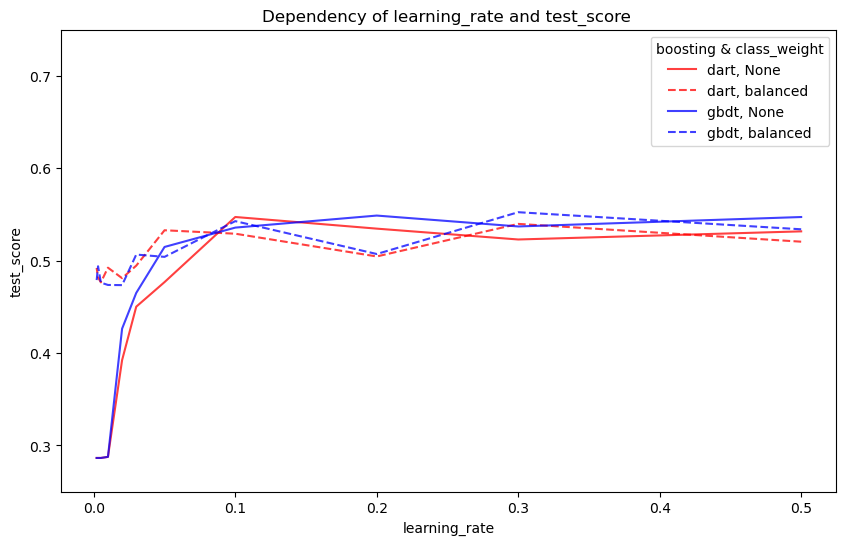

In [16]:
p.draw()